# **Resnet 50**

In [ ]:
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_classes = 3
input_shape = (224, 224, 3)


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Valid',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)

Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define data augmentation techniques
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Load training dataset with data augmentation
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    seed=123,  # Set seed for reproducibility
    shuffle=True,  # Shuffle the dataset
    validation_split=0.2,  # Split data into training and validation sets
    subset='training',  # Specify that this is the training set
)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).map(lambda x, y: (data_augmentation(x), y))

# Load validation dataset
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Valid',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    seed=123,  # Ensure the same seed as training for consistency
    shuffle=True,  # Shuffle the dataset
    validation_split=0.2,  # Split data into training and validation sets
    subset='validation',  # Specify that this is the validation set
)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the model (using a pre-trained CNN model)
base_model = keras.applications.ResNet50(
    include_top=False,  # Exclude the top dense layers
    weights='imagenet',  # Initialize with pre-trained weights
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base model's weights

# Add additional layers for classification
flatten_layer = keras.layers.Flatten()
dropout_layer = keras.layers.Dropout(0.5)
output_layer = keras.layers.Dense(num_classes, activation='softmax')

# Build the model
model = keras.Sequential([
    base_model,
    flatten_layer,
    dropout_layer,
    output_layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds,
                    epochs=20,  # Increase number of epochs for real training
                    validation_data=validation_ds,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

# Evaluate the model on the test set
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)
test_accuracy = model.evaluate(test_ds)
print("Test Accuracy:", test_accuracy[1])


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

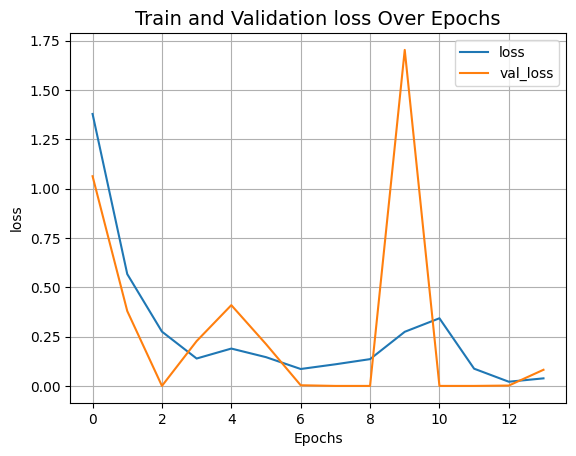

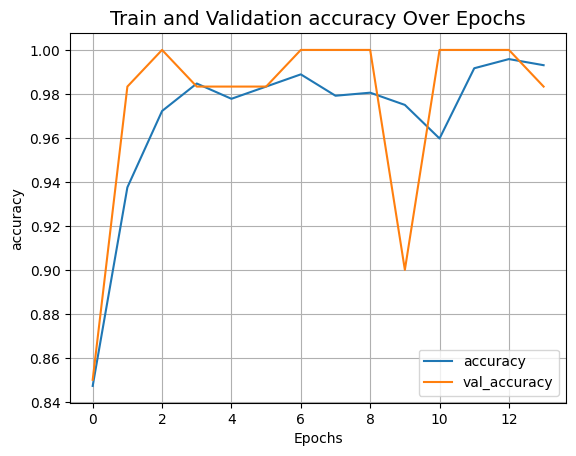

In [ ]:
import matplotlib.pyplot as plt

def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 23888771 (91.13 MB)
Trainable params: 301059 (1.15 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# import numpy as np

# # Predict on the test set
# y_pred = model.predict(test_ds)
# y_true = np.concatenate([y for x, y in test_ds], axis=0)

# # Calculate AUC and ROC curves
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(3):  # Assuming you have 3 classes
#     fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves
# plt.figure()
# for i in range(3):
#     plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(i, roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()


10/10 [==============================] - 3s 98ms/step


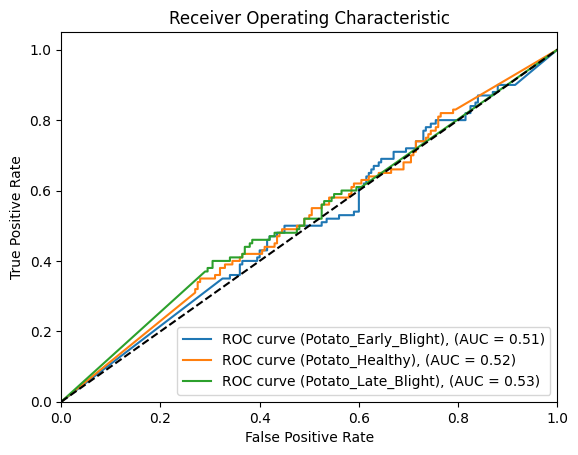

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']  # Assuming 'Potato_Early' is the first class

# Predict on the test set
y_pred = model.predict(test_ds)
# print(y_pred)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate AUC and ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_name in enumerate(class_names):
    class_index = i  # Assuming class index corresponds to its position in class_names
    fpr[class_name], tpr[class_name], _ = roc_curve(y_true[:, class_index], y_pred[:, class_index])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

# Plot ROC curves
plt.figure()
for class_name in class_names:
    plt.plot(fpr[class_name], tpr[class_name], label='ROC curve ({}), (AUC = {:.2f})'.format(class_name, roc_auc[class_name]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
target_names = ['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']  # Adjust class names accordingly
class_report = classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), target_names=target_names, output_dict=True, zero_division='warn')

# Print classification report
print("Classification Report:")
for class_name, metrics in class_report.items():
    if class_name in target_names:
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']}")
        print(f"Recall: {metrics['recall']}")
        print(f"F1-score: {metrics['f1-score']}")
        # Calculate accuracy manually
        accuracy = (metrics['precision'] + metrics['recall']) / 2
        print(f"Accuracy: {accuracy}")


10/10 [==============================] - 2s 97ms/step
Classification Report:

Class: Potato_Early_Blight
Precision: 0.3584905660377358
Recall: 0.38
F1-score: 0.3689320388349514
Accuracy: 0.36924528301886794

Class: Potato_Healthy
Precision: 0.28421052631578947
Recall: 0.27
F1-score: 0.27692307692307694
Accuracy: 0.27710526315789474

Class: Potato_Late_Blight
Precision: 0.3333333333333333
Recall: 0.33
F1-score: 0.3316582914572864
Accuracy: 0.33166666666666667


# **Vision Transformer Model**

In [ ]:
!pip install keras-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.5 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name 'ops' from 'keras' (/usr/local/lib/python3.10/dist-packages/keras/__init__.py)

In [ ]:
num_classes = 3
input_shape = (224, 224, 3)

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Valid',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
image_size = 128  # Replace with the desired image size

In [ ]:
# Define the data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [ ]:
# Load the training data
x_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato/Train",
    image_size=(image_size, image_size),
    batch_size=32,
)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define train_ds here, for example:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato/Train",
    image_size=(image_size, image_size),
    batch_size=32,
)

In [ ]:
!pip install tensorflow-addons

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Define the Patches class
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Assuming train_ds is your TensorFlow dataset
plt.figure(figsize=(4, 4))

# Define image_size and patch_size
image_size = 224
patch_size = 16

for images, labels in train_ds.take(1):  # Assuming you just want to visualize the first batch
    image = images[np.random.choice(range(images.shape[0]))]
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(image_size, image_size)
    )
    patches_layer = Patches(patch_size)
    patches = patches_layer(resized_image)
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")

plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf


def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))



# Function to display images



def display_images(I):
    # Load the image
    # I = cv2.imread(image_path)
    # Display the original imagei
    # plt.figure()I
    I=cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    # Display Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis("off")
    # plt.show()

    # Scaling
    s = 3
    j = cv2.resize(I, None, fx=s, fy=s)
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(j, cv2.COLOR_BGR2RGB))
    plt.title('Scaled Image')
    plt.axis("off")
    # plt.show()

    # Rotation
    K = rotate_image(j, 60)
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(K, cv2.COLOR_BGR2RGB))
    plt.title('Rotated Image 60deg')
    plt.axis("off")
    # plt.show()

    R = rotate_image(j, -45)
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(R, cv2.COLOR_BGR2RGB))
    plt.title('Rotated Image 45deg')
    plt.axis("off")
    # plt.show()

    plt.tight_layout()
    plt.show()

    # Rest of the code for Resized images using different methods...
    # Display the color image and its Resized images by different methods
    plt.figure()

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis("off")
    # plt.show()

    # Display Resized image by Bilinear method
    B = cv2.resize(I, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(B, cv2.COLOR_BGR2RGB))
    plt.title('Bilinear Image')
    plt.axis("off")
    # plt.show()

    # Display Resized image by Nearest method
    C = cv2.resize(I, None, fx=5, fy=5, interpolation=cv2.INTER_NEAREST)
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(C, cv2.COLOR_BGR2RGB))
    plt.title('Nearest Image')
    plt.axis("off")
    # plt.show()

    # Display Resized image by Bicubic method
    D = cv2.resize(I, None, fx=5, fy=5, interpolation=cv2.INTER_CUBIC)
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(D, cv2.COLOR_BGR2RGB))
    plt.title('Bicubic Image')
    plt.axis("off")
    # plt.show()

# Function to enhance images
# def enhance_image(image):
#     image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Image Enhancement
#     plt.subplot(4,2,1)
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.title('Original Image')
#     plt.axis("off")

#     g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     plt.subplot(4,2,3)
#     plt.imshow(g, cmap='gray')
#     plt.title('Gray Image')
#     plt.axis("off")

#     # Image Enhancement using imadjust
#     J = cv2.convertScaleAbs(g, alpha=0.7, beta=76)  # Equivalent to imadjust(g, [0 255], [0.3*255 0.7*255])
#     plt.subplot(4,2,4)
#     plt.imshow(J, cmap='gray')
#     plt.title('Enhanced Image')
#     plt.axis("off")

#     # Separate color channels
#     b, g, r = cv2.split(image)

#     # Adjust each channel separately
#     b = cv2.convertScaleAbs(b, alpha=0.2, beta=76)
#     g = cv2.convertScaleAbs(g, alpha=0.3, beta=76)
#     # Red channel is not adjusted to keep it unchanged.

#     # Merge the channels back together
#     D = cv2.merge([b, g, r])
#     plt.subplot(4,2,5)
#     plt.imshow(cv2.cvtColor(D, cv2.COLOR_BGR2RGB))
#     plt.title('Enhanced Image 2')
#     plt.axis("off")

#     # Histogram and Histogram Equalization
#     plt.subplot(4,2,6)
#     plt.hist(g.ravel(), bins=256, range=[0, 256], color='b', alpha=0.7)
#     plt.title('Histogram of Gray Image')
#     # plt.axis("off")

#     m = cv2.equalizeHist(g)
#     plt.subplot(4, 2, 7)
#     plt.imshow(m, cmap='gray')
#     plt.title('Equalized Image')
#     plt.axis("off")

#     plt.subplot(4, 2, 8)
#     plt.hist(m.ravel(), bins=256, range=[0, 256], color='b', alpha=0.7)
#     plt.title('Histogram of Equalized Image')
#     # plt.axis("off")

#     plt.tight_layout()
#     plt.show()

def enhance_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Image Enhancement
    fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # Larger figure size
    plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis("off")

    g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    axes[1, 0].imshow(g, cmap='gray')
    axes[1, 0].set_title('Gray Image')
    axes[1, 0].axis("off")

    # Image Enhancement using imadjust
    J = cv2.convertScaleAbs(g, alpha=0.7, beta=76)
    axes[1, 1].imshow(J, cmap='gray')
    axes[1, 1].set_title('Enhanced Image')
    axes[1, 1].axis("off")

    # Separate color channels
    b, g, r = cv2.split(image)

    # Adjust each channel separately
    b = cv2.convertScaleAbs(b, alpha=0.2, beta=76)
    g = cv2.convertScaleAbs(g, alpha=0.3, beta=76)
    # Red channel is not adjusted to keep it unchanged.

    # Merge the channels back together
    D = cv2.merge([b, g, r])
    axes[2, 0].imshow(cv2.cvtColor(D, cv2.COLOR_BGR2RGB))
    axes[2, 0].set_title('Enhanced Image 2')
    axes[2, 0].axis("off")

    # Histogram and Histogram Equalization
    axes[2, 1].hist(g.ravel(), bins=256, range=[0, 256], color='b', alpha=0.7)
    axes[2, 1].set_title('Histogram of Gray Image')

    m = cv2.equalizeHist(g)
    axes[3, 0].imshow(m, cmap='gray')
    axes[3, 0].set_title('Equalized Image')
    axes[3, 0].axis("off")

    axes[3, 1].hist(m.ravel(), bins=256, range=[0, 256], color='b', alpha=0.7)
    axes[3, 1].set_title('Histogram of Equalized Image')

    plt.show()





for images, labels in train_ds.take(1):
    # Display the first image in the batch
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()
    # Display the first label in the batch
    print(labels[0].numpy())
    display_images(images[0].numpy().astype("uint8"))
    enhance_image(images[0].numpy().astype("uint8"))
    break
    # enhance_image(images[0].numpy().astype("uint8"))


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define input shape
input_shape = (224, 224, 3)  # Example shape, replace with your input shape

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.

    # Define the rest of your model architecture here
    # Example:
    x = layers.Conv2D(64, 3, activation='relu')(augmented)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

mo = create_vit_classifier()
mo.summary()


In [ ]:
learning_rate = 0.001

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define input shape
input_shape = (224, 224, 3)  # Example shape, replace with your input shape

# Define weight_decay, learning_rate, batch_size, and validation_ds
weight_decay = 0.001  # Example value, replace with your desired weight decay
learning_rate = 0.001  # Example value, replace with your desired learning rate
batch_size = 32  # Example value, replace with your desired batch size

# Define your train and validation datasets (train_ds and validation_ds)

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.

    # Define the rest of your model architecture here
    # Example:
    x = layers.Conv2D(64, 3, activation='relu')(augmented)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification, so output size should be 1

    model = keras.Model(inputs, outputs)
    return model

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),  # No need for from_logits=True
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            # keras.metrics.BinaryTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=30,
        validation_split=0.1,
        validation_data=validation_ds,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    loss, accuracy = model.evaluate(validation_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

# Preprocess function to resize images
def preprocess_data(image, label):
    image = tf.image.resize(image, (224, 224))
    # Other preprocessing steps if necessary
    return image, label

# Preprocess the training dataset
train_ds = train_ds.map(preprocess_data)

validation_data_dir = '/content/drive/MyDrive/Potato/Valid'

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    image_size=(224, 224),
    batch_size=batch_size
)

# Assuming train_ds and validation_ds are defined elsewhere
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


In [ ]:
import os

# Define the paths to the train, test, and validation folders
train_path = '/content/drive/MyDrive/Potato/Train'
test_path = '/content/drive/MyDrive/Potato/Test'
valid_path = '/content/drive/MyDrive/Potato/Valid'

# Function to count the total number of images in a directory
def count_images(directory):
    total_images = sum([len(files) for _, _, files in os.walk(directory)])
    return total_images

# Print the number of classes and class names in the training dataset
train_classes = os.listdir(train_path)
print("Number of classes in the training dataset:", len(train_classes))
print("Class names in the training dataset:", train_classes)

# Print the total number of images in the training dataset
total_train_images = count_images(train_path)
print("Total number of images in the training dataset:", total_train_images)

# Print the number of classes and class names in the validation dataset
valid_classes = os.listdir(valid_path)
print("\nNumber of classes in the validation dataset:", len(valid_classes))
print("Class names in the validation dataset:", valid_classes)

# Print the total number of images in the validation dataset
total_valid_images = count_images(valid_path)
print("Total number of images in the validation dataset:", total_valid_images)

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from tabulate import tabulate

# Predict on the test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
target_names = ['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']  # Adjust class names accordingly
class_report = classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), target_names=target_names, output_dict=True)

# Convert classification report dictionary to a table
report_table = []
for class_name, metrics in class_report.items():
    if class_name in target_names:
        row = [class_name, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']]
        report_table.append(row)

headers = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']
print(tabulate(report_table, headers=headers, tablefmt='grid'))


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']  # Assuming 'Potato_Early' is the first class

# Predict on the test set
y_pred = model.predict(test_ds)
# print(y_pred)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate AUC and ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_name in enumerate(class_names):
    class_index = i  # Assuming class index corresponds to its position in class_names
    fpr[class_name], tpr[class_name], _ = roc_curve(y_true[:, class_index], y_pred[:, class_index])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

# Plot ROC curves
plt.figure()
for class_name in class_names:
    plt.plot(fpr[class_name], tpr[class_name], label='ROC curve ({}), (AUC = {:.2f})'.format(class_name, roc_auc[class_name]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# **HYBRID MODEL**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define ResNet50 model
base_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Extract feature maps
feature_extractor = keras.Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def create_vit_classifier():
    inputs = keras.Input(shape=(7, 7, 2048))
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)  # Adjust the number of units to match the number of classes
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Combine ResNet50 and Vision Transformer models
def hybrid_model():
    resnet_input = keras.Input(shape=(224, 224, 3))
    resnet_features = feature_extractor(resnet_input)
    # Reshape the feature maps to match the Vision Transformer input
    resized_features = keras.layers.Reshape((7, 7, 2048))(resnet_features)
    vit_output = create_vit_classifier()(resized_features)
    model = keras.Model(inputs=resnet_input, outputs=vit_output)
    return model

# Load the datasets
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Potato/Valid',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)

# Compile and train the combined model
model = hybrid_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=50,
                    validation_data=validation_ds,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

# Evaluate the model on the test set
test_accuracy = model.evaluate(test_ds)
print("Test Accuracy:", test_accuracy[1])


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Calculate train and test error
train_error = 1 - history.history['accuracy'][-1]  # Final training accuracy
test_error = 1 - test_accuracy[1]  # Test accuracy from evaluation
print("Train Error:", train_error)
print("Test Error:", test_error)


In [ ]:
model.summary()

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']  # Assuming 'Potato_Early' is the first class

# Predict on the test set
y_pred = model.predict(test_ds)
# print(y_pred)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate AUC and ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_name in enumerate(class_names):
    class_index = i  # Assuming class index corresponds to its position in class_names
    fpr[class_name], tpr[class_name], _ = roc_curve(y_true[:, class_index], y_pred[:, class_index])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

# Plot ROC curves
plt.figure()
for class_name in class_names:
    plt.plot(fpr[class_name], tpr[class_name], label='ROC curve ({}), (AUC = {:.2f})'.format(class_name, roc_auc[class_name]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from tabulate import tabulate

# Predict on the test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
target_names = ['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']  # Adjust class names accordingly
class_report = classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), target_names=target_names, output_dict=True)

# Convert classification report dictionary to a table
report_table = []
for class_name, metrics in class_report.items():
    if class_name in target_names:
        row = [class_name, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']]
        report_table.append(row)

headers = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']
print(tabulate(report_table, headers=headers, tablefmt='grid'))
